Epoch [1/20], Loss: 0.0314
Epoch [2/20], Loss: 0.0012
Epoch [3/20], Loss: 0.0006
Epoch [4/20], Loss: 0.0006
Epoch [5/20], Loss: 0.0006
Epoch [6/20], Loss: 0.0006
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0005
Epoch [9/20], Loss: 0.0005
Epoch [10/20], Loss: 0.0005
Epoch [11/20], Loss: 0.0005
Epoch [12/20], Loss: 0.0005
Epoch [13/20], Loss: 0.0005
Epoch [14/20], Loss: 0.0005
Epoch [15/20], Loss: 0.0005
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0005
Epoch [18/20], Loss: 0.0005
Epoch [19/20], Loss: 0.0005
Epoch [20/20], Loss: 0.0006


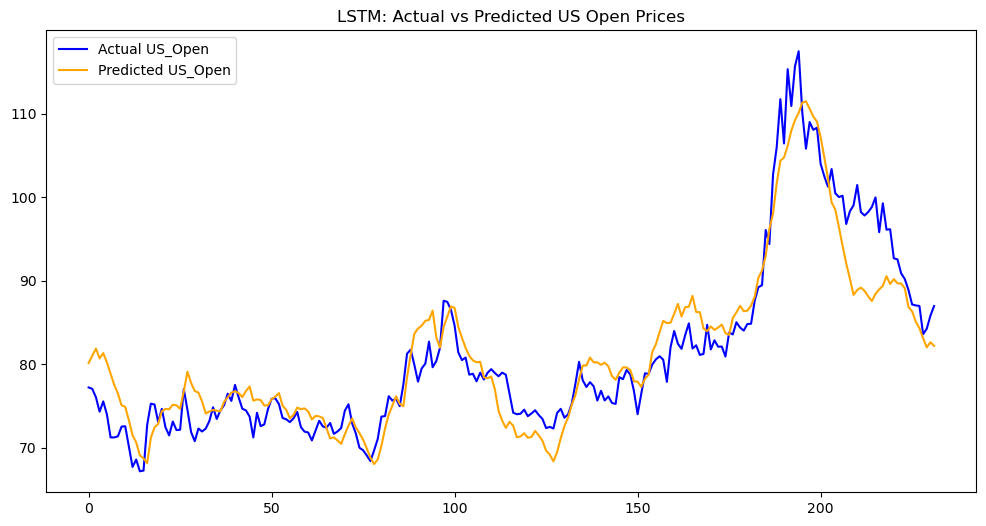

Mean Squared Error: 13.8012


In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from LSTM import LSTMModel
from torch.utils.data import DataLoader, TensorDataset

# Load data
df = pd.read_csv('stock_data.csv')

# Features and target
X = df[['HK_Close', 'US_Close', 'VIX', 'Treasury_Yield', 'RSI_US', 'US_HK_Ratio', 'US_Volume', 'HK_Volume', 'US_MA20', 'HK_MA20']]
y = df['US_Open']

# Scale features and target using MinMaxScaler fitted only on training data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the whole dataset (fitting on training only)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Sequential train-test split: first 80% for training, rest for testing
train_size = int(0.8 * len(X))
X_train_scaled = X_scaled[:train_size]
X_test_scaled = X_scaled[train_size:]
y_train_scaled = y_scaled[:train_size]
y_test_scaled = y_scaled[train_size:]

# Create sequences for LSTM
def create_sequences(data, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

# Number of historical timesteps to consider
timesteps = 20  # Increased from 10 to 20 to capture more historical context

# Create sequences for train and test sets
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32)

# Create DataLoader for batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model parameters
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 200                     # Increased number of LSTM units
num_layers = 2                        # Increased number of LSTM layers
output_size = 1                       # Single output (US_Open)
dropout = 0.3                         # Increased dropout rate to prevent overfitting

# Instantiate the model with Bidirectional LSTM
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(ImprovedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        # Forward propagate through LSTM
        out, _ = self.lstm(x)
        # Pass the last time step output to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

model = ImprovedLSTMModel(input_size, hidden_size, num_layers, output_size, dropout)

# Loss function and optimizer
criterion = nn.SmoothL1Loss()  # Changed to Huber Loss to handle outliers better
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate for finer updates

# Early stopping parameters
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

# Training the model
num_epochs = 20  # Increased epochs to allow for more training
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Early stopping logic
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred.numpy())
    y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.numpy())

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual US_Open", color='blue')
plt.plot(y_pred_rescaled, label="Predicted US_Open", color='orange')
plt.legend()
plt.title("LSTM: Actual vs Predicted US Open Prices")
plt.show()

# Calculate evaluation metrics
mse = np.mean((y_test_rescaled - y_pred_rescaled)**2)
print(f"Mean Squared Error: {mse:.4f}")



=== Trading Performance Summary ===
Initial Cash: 100000.00
Final Portfolio Value: 102724.97
Portfolio Growth: 2.72%
Total Buys: 70, Total Sells: 70
-----------------------------------



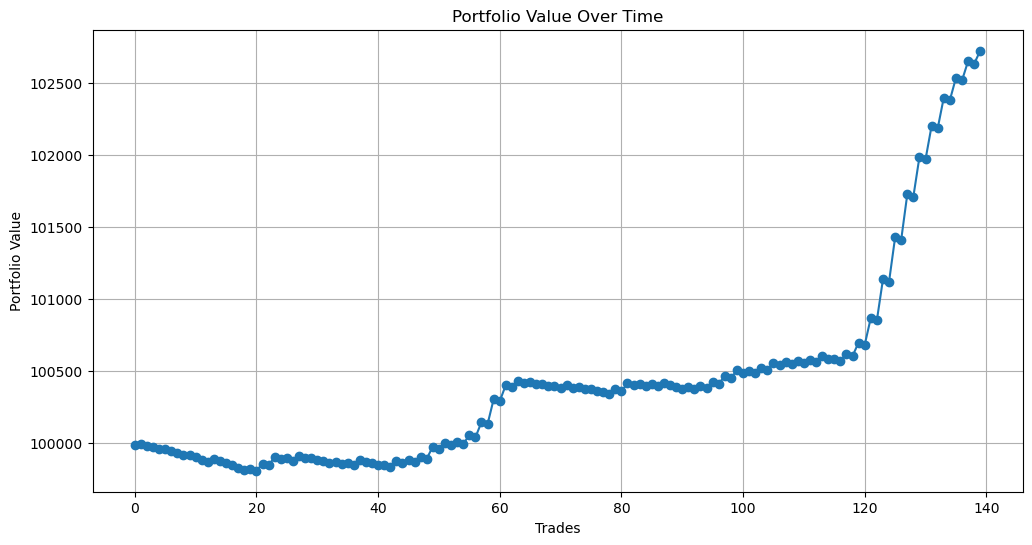

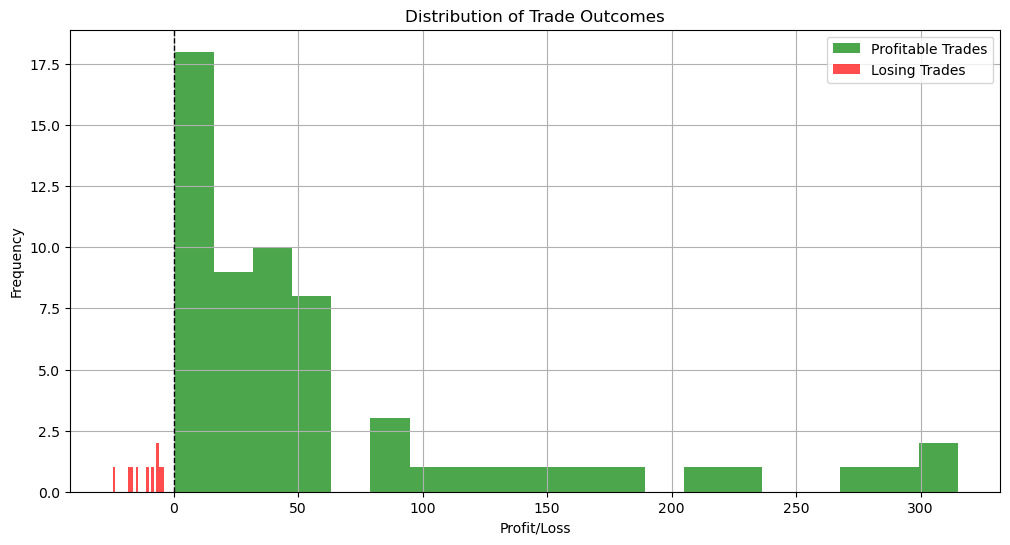


=== Performance Metrics ===
Total Profit: 3784.59
Total Trades: 70
Win Rate: 85.71%
----------------------------


Trade Log (First 10 rows):
  Action      Price  Quantity  Profit/Loss  Portfolio Value
0    BUY  74.564099        10     0.000000     99985.087180
1   SELL  77.059998        10     9.546982     99994.634162
2    BUY  73.692306        10     0.000000     99979.895701
3   SELL  74.330002        10    -8.489043     99971.406657
4    BUY  72.307692        10     0.000000     99956.945119
5   SELL  74.000000        10     2.123077     99959.068196
6    BUY  71.487176        10     0.000000     99944.770760
7   SELL  71.250000        10   -16.621764     99928.148997
8    BUY  70.564106        10     0.000000     99914.036176
9   SELL  72.544998        10     5.299925     99919.336101


In [7]:
from TradingSimulator import TradingSimulator
import pandas as pd

# Sequential train-test split, using the first 80% for training and the remaining 20% for testing
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Extract features and target
X_train = train[['HK_Close', 'US_Close', 'VIX', 'Treasury_Yield', 'RSI_US', 'US_HK_Ratio', 'US_Volume', 'HK_Volume', 'US_MA20', 'HK_MA20']]
y_train = train['US_Open']
X_test = test[['HK_Close', 'US_Close', 'VIX', 'Treasury_Yield', 'RSI_US', 'US_HK_Ratio', 'US_Volume', 'HK_Volume', 'US_MA20', 'HK_MA20']]
y_test = test['US_Open']

# Generate trading signals based on predicted and actual values
def generate_signals(hk_close, us_open_pred, threshold=0.01):
    # Convert to NumPy arrays if needed
    hk_close = hk_close.to_numpy().flatten() if isinstance(hk_close, pd.Series) else hk_close
    us_open_pred = us_open_pred.to_numpy().flatten() if isinstance(us_open_pred, pd.Series) else us_open_pred

    # Create DataFrame from NumPy arrays
    signals = pd.DataFrame({'HK_Close': hk_close, 'US_Open_Pred': us_open_pred})
    
    # Determine signals
    def determine_signal(row):
        hk_close = row['HK_Close']
        us_open_pred = row['US_Open_Pred']
        
        # Calculate percentage difference
        percent_diff = (us_open_pred - hk_close) / hk_close
        
        if percent_diff > threshold:
            return 1  # Buy
        elif percent_diff < -threshold:
            return -1  # Sell
        else:
            return 0  # Hold

    signals['signal'] = signals.apply(determine_signal, axis=1)
    return signals

# Prepare the test dataset with proper alignment
min_length = min(len(X_test), len(y_test_rescaled), len(y_pred_rescaled))

# Trim the test dataset and predictions to avoid misalignment
X_test_trimmed = X_test.iloc[:min_length].reset_index(drop=True)
df_test = test.iloc[:min_length].reset_index(drop=True)
y_test_rescaled = y_test_rescaled[:min_length]
y_pred_rescaled = y_pred_rescaled[:min_length]

# Add the actual and predicted values
df_test['HK_Close'] = X_test_trimmed['HK_Close']  # HK_Close column for generating signals
df_test['Actual'] = y_test_rescaled.flatten()  # Flatten if needed
df_test['Predicted'] = y_pred_rescaled.flatten()  # Flatten if needed

# Generate trading signals based on HK Close and predicted US Open
signals = generate_signals(df_test['HK_Close'], df_test['Predicted'])
df_test['signal'] = signals['signal']

# Initialize and run the simulator
simulator = TradingSimulator(initial_cash=100000, transaction_fee=0.02)

# UPDATED LOGIC:
# Buy at the HK close price and sell at the next US open price, ensuring sequential trading.

# Track whether we have an open position to sell
position_open = False

# Iterate over each row in the test dataset to simulate the buy/sell strategy
for index, row in df_test.iterrows():
    if row['signal'] == 1 and not position_open:  # Buy signal based on HK close, no open position
        # Buy at the HK close price
        simulator.buy(row['HK_Close'])
        position_open = True  # Mark position as open

    elif position_open:  # Sell signal follows immediately after a buy
        # Sell at the next available US open price (if we have an open position)
        simulator.sell(row['Actual'])
        position_open = False  # Close the position

# Evaluate results
final_price = df_test['Actual'].iloc[-1]
simulator.summary(final_price)
simulator.plot_portfolio_growth()
simulator.plot_trade_outcomes()
simulator.calculate_metrics()

# Display the trade log
trade_log = simulator.get_trade_log()
print("\nTrade Log (First 10 rows):")
print(trade_log.head(10))
